# U.S. Geological Survey Class GW3099
Advanced Modeling of Groundwater Flow (GW3099)\
Boise, Idaho\
September 16 - 20, 2024

![title](../../images/ClassLocation.jpg)

## Aquifer thermal energy storage (ATES) example

This notebook demonstrates application of a MODFLOW 6 groundwater energy transport (GWE) model to simulate a aquifer thermal energy storage (ATES) for storing (or extracting) energy from an aquifer over an annually repeating period

Where as the previous exercised used a DISU grid, this model uses a DISV grid type.  The flow system consists of three layers of marginally porous material, where the upper and lower layers share the same hydraulic and thermal properties. Water is injected and extracted into the middle layer sandwiched between the upper and lower layers.  Hydraulic and thermal properties in the middle layer are distinct from the upper and lower layers.

Energy is loaded into the left side of the domain by specifying the temperature of the injected water.  Water is extracted from the aquifer at its calculated temperature.

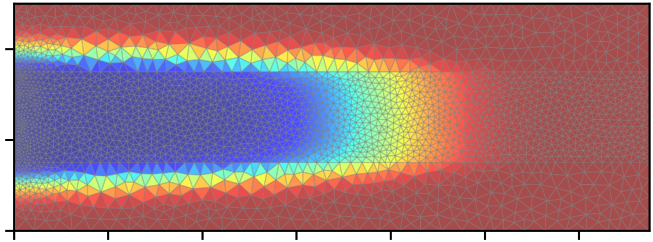

In [ ]:
# Import dependencies, define the example name and workspace

import os
import pathlib as pl

# Suppress warning messages
import warnings
from pathlib import Path
from pprint import pformat

import ates_disv_builder_funcs as disv
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.mf6 import MFSimulation
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

### Define parameters

Define model units, parameters and other settings.

In [ ]:
# Model units
length_units = "meters"
time_units = "days"

nper = 127  # Number of stress periods
nlay = 1  # Number of layers
k11_zn1 = 8.64  # Horizontal hydraulic conductivity in middle zone ($m/d$)
k11_zn2 = 0.000864  # Horizontal hydraulic conductivity in upper and lower zones ($m/d$)
icelltype = 0  # Saturated thickness will be held constant
strt = 1000.0  # Starting head ($m$)
ss = 1e-3  # Specific storage ($-$)
sy_zn1 = 0.01  # Specific yield in middle zone ($-$)
sy_zn2 = 0.10  # Specific yield in upper and lower zones ($-$)
prsity_zn1 = 0.01  # 0.005  # Porosity of middle zone ($-$)
prsity_zn2 = 0.10  # 0.05  # Porosity of upper and lower zones ($-$)
# strt_temp = 50.0  # Starting temperature ($^{\circ}C$})
# t_inj = 20  # Temperature of injected water ($^{\circ}C$})
strt_temp = 4.0
t_inj = 25
al = 0.1  # Longitudinal dispersivity ($m$)
ath1 = 0.01  # Transverse dispersivity ($m$)
kts_zn1 = (
    3.0  # Thermal conductivity of middle zone ($\frac{W}{m \cdot ^{\circ} C}$)
)
kts_zn2 = 1.4  # Thermal conductivity of upper and lower zones ($\frac{W}{m \cdot ^{\circ} C}$)
ktw = 0.58  # Thermal conductivity of water ($\frac{W}{m \cdot ^{\circ} C}$)
cps_zn1 = (
    1100.0  # Heat capacity of middle zone ($\frac{J}{kg \cdot ^{\circ} C}$)
)
cps_zn2 = 350.0  # Heat capacity of upper and lower zones ($\frac{J}{kg \cdot ^{\circ} C}$)
cpw = 4180.0  # Heat capacity of water ($\frac{J}{kg \cdot ^{\circ} C}$)
rhow = 1000.0  # Density of water ($kg/m^3$)
rhos = 2500.0  # Density of dry solid aquifer material ($kg/m^3$)
lhv = 2500.0  # Latent heat of vaporization ($kJ/kg$)
scheme = "TVD"  # Advection solution scheme ($-$)

# Stress period pumping
welq = [
    0.0,
    0.0,
    -9.6,
    -19.3,
    -28.9,
    -38.6,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -38.6,
    -28.9,
    -19.3,
    -9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    9.6,
    19.3,
    28.9,
    38.6,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    38.6,
    28.9,
    19.3,
    9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    -9.6,
    -19.3,
    -28.9,
    -38.6,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -38.6,
    -28.9,
    -19.3,
    -9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    9.6,
    19.3,
    28.9,
    38.6,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    38.6,
    28.9,
    19.3,
    9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    -9.6,
    -19.3,
    -28.9,
    -38.6,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -38.6,
    -28.9,
    -19.3,
    -9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    9.6,
    19.3,
    28.9,
    38.6,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    48.2,
    38.6,
    28.9,
    19.3,
    9.6,
    0.0,
    0.0,
    0.0,
    0.0,
    -9.6,
    -19.3,
    -28.9,
    -38.6,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -48.2,
    -38.6,
    -28.9,
    -19.3,
    -9.6,
    0.0,
    0.0,
    0.0,
]

# Model timing
nper = len(welq)
perlen = [10] * nper
nstp = [1] * nper
tsmult = [1.0] * nper
unitconv = 86400

# Solver parameters
nouter, ninner = 200, 300
hclose, rclose, relax = 1e-7, 1e-3, 0.97
transient = {0: True}

#### Examining the pumping time series

In [ ]:
df = (
    pd.date_range("1970-01-01", "1973-06-15", freq="10D")
    .to_frame(name="date")
    .reset_index(drop=True)
)
df["q"] = welq
df = df.set_index("date")
df.head

fig = plt.subplots(figsize=(10, 4))

# Creating a plot
plt.plot(df.index, df["q"])
plt.axhline(y=0.0, color="r", linestyle="-")

# Adding a plot title and customizing its font size
plt.title("Injection/Extraction", fontsize=10)

# Adding axis labels and customizing their font size
plt.xlabel("Date", fontsize=10)
plt.ylabel("Rate", fontsize=10)

# Rotaing axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)

### Load a file stored in the data directory for building out the DISV grid

In [ ]:
fname = "ates_disv_nodes.fem"
fpath = os.path.join(os.getcwd(), fname)
assert os.path.isfile(fpath), "file not present"

### Build-out objects required for DISV grid instantiation

In [ ]:
verts, cell2d, inQ_iverts = disv.read_finite_element_mesh(fpath)
top = np.ones((len(cell2d),))
botm = np.zeros((1, len(cell2d)))

# Use FloPy utility function
modelgrid = flopy.discretization.VertexGrid(verts, cell2d, top=top, botm=botm)

#### Function for building a GWF model

In [ ]:
def build_gwf(sim, gwfname):
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
    )

    # create iterative model solution and register the gwf model with it
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="SIMPLE",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="DBD",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nogrb=True,
        ncpl=len(cell2d),
        nvert=len(verts),
        nlay=nlay,
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV",
        filename="{}.disv".format(gwfname),
    )

    # Instantiating MODFLOW 6 node property flow package
    # Determine which K zone each element falls in:
    low_k_id, high_k_id = disv.determine_zone(cell2d)

    # Set 1D K list based on results of previous function
    k11 = disv.determine_param(low_k_id, high_k_id, k11_zn1, k11_zn2, "k")

    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        # xt3doptions="XT3D",
        k=k11,
        save_specific_discharge=True,
        save_saturation=True,
        pname="NPF",
        filename="{}.npf".format(gwfname),
    )

    # Instatiating MODFLOW 6 initial conditions package
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    # Instantiating MODFLOW 6 storage package
    sy = disv.determine_param(low_k_id, high_k_id, sy_zn1, sy_zn2, "sy")
    flopy.mf6.ModflowGwfsto(
        gwf,
        ss=ss,
        sy=sy,
        transient={0: True},
        pname="STO",
        filename="{}.sto".format(gwfname),
    )

    # Instantiate WEL package
    # Determine which CVs are on the right and left boundary
    left_bnd, right_bnd = disv.determine_bnd(cell2d, verts)
    wel_spd = {}
    adj_factor = 0.01
    for tm, q in enumerate(welq):
        wel_q = []
        for cellid in left_bnd:
            if q > 0.0:
                q_temp = t_inj
            else:
                q_temp = 0.0

            q_adj = q * adj_factor
            wel_q.append([(0, cellid), q_adj, q_temp])

        wel_spd.update({tm: wel_q})

    flopy.mf6.ModflowGwfwel(
        gwf,
        auxiliary="TEMPERATURE",
        save_flows=True,
        stress_period_data=wel_spd,
        pname="WEL",
        filename="{}.wel".format(gwfname),
    )

    # Instantiating MODFLOW 6 output control package (flow model)
    head_filerecord = "{}.hds".format(gwfname)
    budget_filerecord = "{}.cbc".format(gwfname)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "All"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim

#### Function for building a GWE model that matches the GWF model

In [ ]:
def build_gwe(sim, gwename):
    # Instantiating MODFLOW 6 groundwater transport model
    gwe = flopy.mf6.MFModel(
        sim,
        model_type="gwe6",
        modelname=gwename,
        model_nam_file="{}.nam".format(gwename),
    )

    # Create iterative model solution and register the gwe model with it
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        complexity="SIMPLE",
        no_ptcrecord="all",
        linear_acceleration="bicgstab",
        scaling_method="NONE",
        reordering_method="NONE",
        outer_maximum=nouter,
        outer_dvclose=hclose * 1000,
        under_relaxation="dbd",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_maximum=ninner,
        inner_dvclose=hclose * 1000,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
        rcloserecord="{} strict".format(rclose),
        filename="{}.ims".format(gwename),
    )
    sim.register_ims_package(imsgwe, [gwe.name])

    # Instantiating MODFLOW 6 heat transport discretization package
    flopy.mf6.ModflowGwedisv(
        gwe,
        nogrb=True,
        nlay=nlay,
        ncpl=len(cell2d),
        nvert=len(verts),
        top=top,
        botm=botm,
        idomain=1,
        vertices=verts,
        cell2d=cell2d,
        pname="DISV-GWE",
        filename="{}.disv".format(gwename),
    )

    # Determine zonation scheme each disv element (cell) falls in:
    low_k_id, high_k_id = disv.determine_zone(cell2d)

    # Instantiating MODFLOW 6 heat transport initial temperature
    flopy.mf6.ModflowGweic(
        gwe, strt=strt_temp, pname="IC", filename="{}.ic".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport advection package
    flopy.mf6.ModflowGweadv(
        gwe, scheme=scheme, pname="ADV", filename="{}.adv".format(gwename)
    )

    # Instantiating MODFLOW 6 heat transport energy storage package (consider renaming to est)
    prsity = disv.determine_param(
        low_k_id, high_k_id, prsity_zn1, prsity_zn2, "prsity"
    )
    cps = disv.determine_param(low_k_id, high_k_id, cps_zn1, cps_zn2, "cps")
    flopy.mf6.ModflowGweest(
        gwe,
        porosity=prsity,
        heat_capacity_solid=cps,
        density_solid=rhos,
        heat_capacity_water=cpw,
        density_water=rhow,
        pname="EST",
        filename="{}.est".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport dispersion package
    kts = disv.determine_param(
        low_k_id, high_k_id, kts_zn1 * unitconv, kts_zn2 * unitconv, "kts"
    )
    flopy.mf6.ModflowGwecnd(
        gwe,
        xt3d_off=True,
        alh=al,
        ath1=ath1,
        ktw=ktw,
        kts=kts,
        pname="CND",
        filename="{}.cnd".format(gwename),
    )

    # Instantiating MODFLOW 6 source/sink mixing package for dealing with
    # auxiliary temperature specified in WEL boundary package.
    sourcerecarray = [
        ("WEL", "AUX", "TEMPERATURE"),
    ]
    flopy.mf6.ModflowGwessm(
        gwe,
        sources=sourcerecarray,
        pname="SSM",
        filename="{}.ssm".format(gwename),
    )

    # Instantiating MODFLOW 6 heat transport output control package
    flopy.mf6.ModflowGweoc(
        gwe,
        budget_filerecord="{}.cbc".format(gwename),
        temperature_filerecord="{}.ucn".format(gwename),
        temperatureprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("TEMPERATURE", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("TEMPERATURE", "ALL"), ("BUDGET", "ALL")],
        filename=f"{gwename}.oc",
    )

    return sim

### Construct the simulation

In [ ]:
# Simulation name; model names
sim_name = "ates"
gwfname = "gwf-" + sim_name.split("-")[-1]
gwename = "gwe-" + sim_name.split("-")[-1]

sim_ws = Path("./temp/ates")

# Instantiate a simulation
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name, version="mf6", exe_name="mf6", sim_ws=sim_ws
)

# create tdis package
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

flopy.mf6.ModflowTdis(
    sim, time_units=time_units, nper=nper, perioddata=tdis_rc
)

# create gwf model
sim = build_gwf(sim, gwfname)

# create gwe model

sim = build_gwe(sim, gwename)

# Instantiate Gwf-Gwe Exchange package
flopy.mf6.ModflowGwfgwe(
    sim,
    exgtype="GWF6-GWE6",
    exgmnamea=gwfname,
    exgmnameb=gwename,
    filename="{}.gwfgwe".format(gwename),
)

### Write and run the simulation

In [ ]:
sim.write_simulation(silent=False)
success, buff = sim.run_simulation(silent=False, report=True)
# Running the simulation should only take about 15-20 seconds

### View model domain

In [ ]:
gwe = sim.get_model(gwename)
figure_size_bc = (10, 7)
fig = plt.figure(figsize=figure_size_bc)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=gwe, ax=ax)
pmv.plot_grid(alpha=0.5, linewidth=1)
cb = pmv.plot_array(gwe.est.porosity.array, cmap="Set2")
ax.set_xlabel("X, m")
ax.set_ylabel("Y, m")
ax.set_title("Porosity View")
plt.tight_layout()

### Animate model output

In [ ]:
temps = gwe.output.temperature().get_alldata()
vmin = temps.min()
vmax = temps.max()
times = gwe.output.temperature().get_times()

In [ ]:
# make base figure
def create_animation():
    figsize = (10, 7)
    matplotlib.rcParams["animation.embed_limit"] = 2**128
    fig = plt.figure(figsize=figsize)
    # ax = fig.add_subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(
        model=gwe,
    )  # ax=ax)
    pmv.plot_grid(alpha=0.25)
    tempmesh = pmv.plot_array(
        temps[0], alpha=0.7, cmap="jet", vmin=vmin, vmax=vmax
    )
    plt.colorbar(
        tempmesh,
        shrink=0.85,
        # ax=ax,
        label="Temperature",
        location="bottom",
        fraction=0.1,
    )
    plt.xlabel("X, m")
    plt.ylabel("Y, m")
    # ax.set_aspect("equal")
    plt.title(f"Time = {times[0]} days")

    def update(i, *args):
        tempmesh.set_array(temps[i].flatten())
        plt.title(f"Time = {times[i]} days")
        return (tempmesh,)

    ani = FuncAnimation(
        fig, update, range(1, len(times)), interval=100, blit=True
    )  # interval=25,
    return HTML(ani.to_jshtml())

### Generate an animation of the ATES system

In [ ]:
create_animation()

In [ ]:
gwe = sim.get_model(gwename)
lst_pth = sim.sim_path / f"{gwe.name}.lst"
budget_key = "ENERGY BUDGET FOR ENTIRE MODEL AT END OF TIME STEP"
lst = flopy.utils.MfListBudget(lst_pth, budgetkey=budget_key)

In [ ]:
lst_bud = lst.get_dataframes()

In [ ]:
# the 0th index is for the cumulative budget; the 1st index is for the current stress period budget
lst_bud[1].iloc[100]

In [ ]:
dat_in = lst_bud[0].loc[:, "WEL_IN"]
dat_out = lst_bud[0].loc[:, "WEL_OUT"]

In [ ]:
l1 = plt.plot(dat_in, label="Energy Added")
l2 = plt.plot(-dat_out, label="Energy Withdrawn")
l3 = plt.plot(dat_in - dat_out, ".", label="Net")
plt.legend()
plt.axhline(y=0, color="k", linestyle="-")